In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
import seaborn as sns

### Подготовка данных для использования
 - Получение Датасета
 - Получение Даталоадера
 - Просмотр данных

In [2]:
train_dataset = datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform=ToTensor()
)
test_dataset = datasets.MNIST(
    root = './data',
    train = False,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:03<00:00, 2776670.63it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 1935291.90it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [3]:
BATCH_SIZE = 64

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [5]:
### Целевое значение
next(iter(train_dataloader))[1]

tensor([3, 0, 2, 8, 0, 7, 7, 2, 9, 7, 1, 5, 1, 9, 8, 4, 6, 8, 4, 5, 1, 9, 7, 0,
        6, 2, 9, 6, 2, 9, 7, 7, 5, 0, 5, 8, 9, 4, 9, 2, 1, 5, 6, 2, 7, 7, 8, 6,
        4, 4, 3, 7, 2, 9, 5, 8, 8, 9, 7, 0, 0, 2, 0, 5])

In [6]:
### Torch tensor
next(iter(train_dataloader))[0].shape

torch.Size([64, 1, 28, 28])

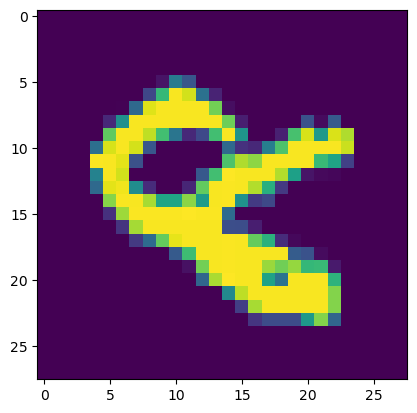

In [7]:
for_show = next(iter(train_dataloader))[0]
plt.imshow(for_show.numpy()[0][0])

### Построим нейронную сеть, чтобы для решения задачи бинарной классфикации (является ли цифра 9-кой или нет)

In [8]:
class IsOne(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.Linear1 = torch.nn.Linear(28*28, 256)
        self.Linear2 = torch.nn.Linear(256, 64)
        self.Linear3 = torch.nn.Linear(64, 1)
        self.relu = torch.nn.ReLU()
        self.Sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        x = x.squeeze(1)
        x = x.flatten(1)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        x = self.relu(x)
        x = self.Linear3(x).squeeze(1)
        x = self.Sigmoid(x)
        return x

In [9]:
model = IsOne()

### Функция, вычисляющая лосс

In [10]:
def loss_function(true, pred):
    loss = torch.nn.BCELoss()
    return loss(pred, true)

### Оптимизатор

In [11]:
optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3)

### Построим процесс обучения нейронной сети

In [12]:
NUM_EPOCHS = 100
WANTED_LABEL = 9

In [13]:
train_loss = []
test_loss = []
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train(True)
    train_loss_epoch = 0
    test_loss_epoch = 0
    for X, y in train_dataloader:
        model.zero_grad()
        true = (y == WANTED_LABEL).float()
        predictions = model.forward(X)
        loss_value = loss_function(true, predictions)
        loss_value.backward()
        train_loss_epoch += loss_value.item()/len(train_dataloader)
        optimizer.step()
    train_loss.append(train_loss_epoch)
    model.train(False)
    for X, y in test_dataloader:
        true = (y == WANTED_LABEL).float()
        predictions = model.forward(X)
        loss_value = loss_function(true, predictions)
        test_loss_epoch += loss_value.item()/len(test_dataloader)
    test_loss.append(test_loss_epoch)
    # print(epoch, train_loss[-1], test_loss[-1])

100%|██████████| 100/100 [13:45<00:00,  8.25s/it]


<Axes: >

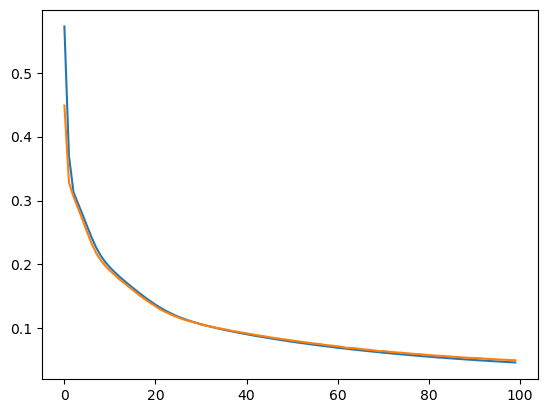

In [14]:
sns.lineplot(train_loss)
sns.lineplot(test_loss)

In [15]:
preds = []
reals = []
for X, y in test_dataloader:
    preds.append(model(X).detach().numpy())
    reals.append((y==WANTED_LABEL).int().numpy())

In [16]:
preds = (np.concatenate(preds)>=0.5).astype(int)

In [17]:
reals = np.concatenate(reals)

In [18]:
from sklearn.metrics import accuracy_score, f1_score

In [19]:
accuracy_score(preds, reals), f1_score(reals, preds)

(0.9846754807692307, 0.9217391304347826)

### Домашняя работа
Изменить нейронную сеть следующим образом:
 - Чтобы она решала задачу не бинарной классификации, а многоклассовой (Для этого нужно использовать другую лосс функцию и функцию активации на выходе)
 - Чтобы в ней было не 2 скрытых слоя, а три
 - Чтобы кол-во нейронов подставлялось через массив, поданный при инициализации класса модели
 - Чтобы происходил dropout (вероятность 0.3) до первого скрытого слоя. Показать, как это изменение повлияло на результат работы модели на тестовой выборке.
 - Посчитать метрики классификации через classification report (sklearn) для каждого класса